## Capstone Assignment - Office Supply Store Data Analysis

### Background:

An office supply store tests a telemarketing campaign to its existing business customers. The company targeted approximately 16,000 customers for the campaign. Assume you are a consultant brought on board to help the company leverage and use the findings from the tests to its advantage. Refer to the accompanying spreadsheet, which contain the results of the tests. 

### Project objectives:

* Profile the customers that responded to the campaign to make the company aware of who its typical customer is.
* Develop models that will allow the company to use the results of the campaign to target future, similar campaigns.
* Show the financial value of your models.

### Expected deliverables:
A deck that details your findings and the models (must include a clear gains chart showing the financial contribution of your results) and the percent of the base that can be profitably targeted for the next campaign.

### Relevant financials:

* Gross margin on sales: 22%

* Campaign cost: `$45.65` per business contacted.

* Transaction cost: $`8.40` per transaction


### Methodology:

* Create model and validation sets
* Develop a model to estimate the probability of responding to this campaign
* Develop a model to estimate the size (dollar) of the transaction
* Calculate the expected profit resulting from each target; use the formula below:
* E(Profit)=.22*Prob(Sale)*Est(Transaction Size)-$ `8.40` *Prob(Sale)- $ `45.65`
* Illustrate the contribution to profitability associated with your models versus random targeting
* Create a presentation for your client

## Import some Libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, precision_recall_curve, classification_report, mean_squared_error, mean_absolute_error
# from sklearn.preprocessing import RobustSca

In [2]:
pd.set_option('display.max_columns', 50)

## Get the data

In [3]:
df = pd.read_excel('data/Office Supply Campaign ResultS 7-23-19.xlsx')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16173 entries, 0 to 16172
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Customer Number                    16172 non-null  float64       
 1   Campaign Period Sales              16172 non-null  float64       
 2   Historical Sales Volume            16172 non-null  float64       
 3   Date of First Purchase             16172 non-null  datetime64[ns]
 4   Number of Prior Year Transactions  16172 non-null  float64       
 5   Do Not Direct Mail Solicit         16172 non-null  float64       
 6   Do Not Email                       16172 non-null  float64       
 7   Do Not Telemarket                  16172 non-null  float64       
 8   Repurchase Method                  16172 non-null  object        
 9   Last Transaction Channel           15730 non-null  object        
 10  Desk                              

In [5]:
df.head()

,Customer Number,Campaign Period Sales,Historical Sales Volume,Date of First Purchase,Number of Prior Year Transactions,Do Not Direct Mail Solicit,Do Not Email,Do Not Telemarket,Repurchase Method,Last Transaction Channel,Desk,Executive Chair,Standard Chair,Monitor,Printer,Computer,Insurance,Toner,Office Supplies,Number of Employees,Language
0,86734.0,238.704762,146803.428571,1968-10-01,15.0,0.0,0.0,0.0,AUTO RENEW,AUTO RENEW,N,N,N,N,N,N,Y,N,Y,6-10,English
1,97098.0,281.680000,439984.160000,1981-06-15,22.0,0.0,0.0,0.0,NOTICE,MAIL,N,N,N,N,N,N,N,N,Y,11-50,English
2,100836.0,432.857143,970465.714286,1962-11-01,19.0,0.0,0.0,0.0,NOTICE,MAIL,N,N,N,N,N,N,N,N,Y,6-10,English
3,116390.0,0.000000,230193.600000,1983-06-01,17.0,0.0,0.0,0.0,NOTICE,PHONE,N,N,N,N,N,N,N,N,Y,1-5,English
4,127914.0,1370.166667,27403.333333,1987-07-15,21.0,0.0,0.0,0.0,NOTICE,BRANCH (PHONE),N,N,N,N,N,N,Y,N,N,,NaN


### Clean the column names

In [6]:
# clean a column names
df.columns = [col.strip().lower().replace(' ', '_') for col in df.columns]

In [7]:
df.head(1)

,customer_number,campaign_period_sales,historical_sales_volume,date_of_first_purchase,number_of_prior_year_transactions,do_not_direct_mail_solicit,do_not_email,do_not_telemarket,repurchase_method,last_transaction_channel,desk,executive_chair,standard_chair,monitor,printer,computer,insurance,toner,office_supplies,number_of_employees,language
0,86734.0,238.704762,146803.428571,1968-10-01,15.0,0.0,0.0,0.0,AUTO RENEW,AUTO RENEW,N,N,N,N,N,N,Y,N,Y,6-10,English


In [8]:
def basic_details(df):
    b = pd.DataFrame()
    b['Missing value'] = df.isnull().sum()
    b['Number of unique value'] = df.nunique()
    b['dtype'] = df.dtypes
    return b
basic_details(df)

,Missing value,Number of unique value,dtype
customer_number,1,16172,float64
campaign_period_sales,1,4322,float64
historical_sales_volume,1,16162,float64
date_of_first_purchase,1,3493,datetime64[ns]
number_of_prior_year_transactions,1,61,float64
do_not_direct_mail_solicit,1,2,float64
do_not_email,1,2,float64
do_not_telemarket,1,2,float64
repurchase_method,1,3,object
last_transaction_channel,443,8,object


# Dealing with missing Data

### Heatmap to visulaize the missing data

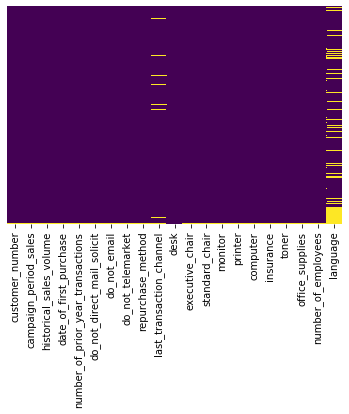

In [10]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis');

* Most of the data in `language` attribuate and  some date in  `last_transaction_channel` attribuate are missing.

------

## Percentage of the missing data for each feature 

In [11]:
def NaN_percent(df, column_name):
    row_count = df[column_name].shape[0]
    empty_values = row_count - df[column_name].count()
    return (100.0*empty_values)/row_count
for i in list(df):
    print(i +': ' + str(NaN_percent(df,i))+'%')  

customer_number: 0.0061831447474185374%
campaign_period_sales: 0.0061831447474185374%
historical_sales_volume: 0.0061831447474185374%
date_of_first_purchase: 0.0061831447474185374%
number_of_prior_year_transactions: 0.0061831447474185374%
do_not_direct_mail_solicit: 0.0061831447474185374%
do_not_email: 0.0061831447474185374%
do_not_telemarket: 0.0061831447474185374%
repurchase_method: 0.0061831447474185374%
last_transaction_channel: 2.739133123106412%
desk: 0.0%
executive_chair: 0.012366289494837075%
standard_chair: 0.012366289494837075%
monitor: 0.012366289494837075%
printer: 0.012366289494837075%
computer: 0.0061831447474185374%
insurance: 0.01854943424225561%
toner: 0.01854943424225561%
office_supplies: 0.0061831447474185374%
number_of_employees: 0.01854943424225561%
language: 27.6510233104557%


-----

* **About 27% of the `language` are missing; 2.7% of `last_transaction_channel` are missing.**

-------------

## Counting these missing values

In [12]:
df.isnull().sum()

customer_number                         1
campaign_period_sales                   1
historical_sales_volume                 1
date_of_first_purchase                  1
number_of_prior_year_transactions       1
do_not_direct_mail_solicit              1
do_not_email                            1
do_not_telemarket                       1
repurchase_method                       1
last_transaction_channel              443
desk                                    0
executive_chair                         2
standard_chair                          2
monitor                                 2
printer                                 2
computer                                1
insurance                               3
toner                                   3
office_supplies                         1
number_of_employees                     3
language                             4472
dtype: int64

-----

In [13]:
 df.language

0        English
1        English
2        English
3        English
4            NaN
          ...   
16168        NaN
16169        NaN
16170        NaN
16171        NaN
16172        NaN
Name: language, Length: 16173, dtype: object

In [15]:
# look for rows missing for certain product entries
idx_missing=df.loc[df.toner.isnull()].index
# df.loc[df.idx_missing]
df.drop(labels=idx_missing, axis=0, inplace=True) # drop missing rows for products.
df.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16170 entries, 0 to 16171
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   customer_number                    16170 non-null  float64       
 1   campaign_period_sales              16170 non-null  float64       
 2   historical_sales_volume            16170 non-null  float64       
 3   date_of_first_purchase             16170 non-null  datetime64[ns]
 4   number_of_prior_year_transactions  16170 non-null  float64       
 5   do_not_direct_mail_solicit         16170 non-null  float64       
 6   do_not_email                       16170 non-null  float64       
 7   do_not_telemarket                  16170 non-null  float64       
 8   repurchase_method                  16170 non-null  object        
 9   last_transaction_channel           15728 non-null  object        
 10  desk                              

In [16]:
df.loc[df.last_transaction_channel.isnull()]
# Get rid of rows missing in ast_transaction_channnel
df.drop(labels=df.loc[df.last_transaction_channel.isnull()].index, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15728 entries, 0 to 16171
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   customer_number                    15728 non-null  float64       
 1   campaign_period_sales              15728 non-null  float64       
 2   historical_sales_volume            15728 non-null  float64       
 3   date_of_first_purchase             15728 non-null  datetime64[ns]
 4   number_of_prior_year_transactions  15728 non-null  float64       
 5   do_not_direct_mail_solicit         15728 non-null  float64       
 6   do_not_email                       15728 non-null  float64       
 7   do_not_telemarket                  15728 non-null  float64       
 8   repurchase_method                  15728 non-null  object        
 9   last_transaction_channel           15728 non-null  object        
 10  desk                              

In [17]:
df.drop(labels=df.loc[df.language.isnull()].index, inplace=True)
df.language.value_counts()

English       11039
Spanish          88
Italian          45
Portuguese       40
Hindi            39
Chinese          30
Russian          24
Hebrew           20
Arabic           16
German           15
Greek            14
Japanese         11
Polish           10
Vietnamese        9
French            6
Korean            4
Thai              2
Pashto            1
Name: language, dtype: int64

In [18]:
df.loc[df.number_of_employees.isnull()]

,customer_number,campaign_period_sales,historical_sales_volume,date_of_first_purchase,number_of_prior_year_transactions,do_not_direct_mail_solicit,do_not_email,do_not_telemarket,repurchase_method,last_transaction_channel,desk,executive_chair,standard_chair,monitor,printer,computer,insurance,toner,office_supplies,number_of_employees,language
10802,24078364.0,3093.454000,6384889.056,1965-08-15,24.0,0.0,1.0,0.0,AUTO RENEW,AUTO RENEW,N,N,N,N,N,Y,Y,Y,Y,NaN,English
11865,26537607.0,234.146667,189658.800,2012-10-30,15.0,0.0,0.0,0.0,NOTICE,WEB,Y,N,N,N,N,N,N,N,Y,NaN,English


In [19]:
df.number_of_employees.value_counts()
# we see we have empyt string

6-10       4775
1-5        2455
11-50      2033
51-100     1264
101-500     599
500+        210
             75
Name: number_of_employees, dtype: int64

In [20]:
idx= df.loc[df.number_of_employees.isnull()].index
df.loc[idx, 'number_of_employees'] = ' '

In [21]:
df.number_of_employees.str.contains(' ')

0        False
1        False
2        False
3        False
5        False
         ...  
14939    False
14941    False
14945    False
14946    False
14947    False
Name: number_of_employees, Length: 11413, dtype: bool

In [22]:
idx_unknown_employees = (df.number_of_employees.str.contains(' '))
# idx = (idx_language_none | idx_unknown_employees)
df.drop(labels=df.loc[idx].index, axis=0).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11411 entries, 0 to 14947
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   customer_number                    11411 non-null  float64       
 1   campaign_period_sales              11411 non-null  float64       
 2   historical_sales_volume            11411 non-null  float64       
 3   date_of_first_purchase             11411 non-null  datetime64[ns]
 4   number_of_prior_year_transactions  11411 non-null  float64       
 5   do_not_direct_mail_solicit         11411 non-null  float64       
 6   do_not_email                       11411 non-null  float64       
 7   do_not_telemarket                  11411 non-null  float64       
 8   repurchase_method                  11411 non-null  object        
 9   last_transaction_channel           11411 non-null  object        
 10  desk                              

In [23]:
idx =(df.number_of_employees.str.contains(' '))
df.drop(labels=df.loc[idx].index, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11336 entries, 0 to 14947
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   customer_number                    11336 non-null  float64       
 1   campaign_period_sales              11336 non-null  float64       
 2   historical_sales_volume            11336 non-null  float64       
 3   date_of_first_purchase             11336 non-null  datetime64[ns]
 4   number_of_prior_year_transactions  11336 non-null  float64       
 5   do_not_direct_mail_solicit         11336 non-null  float64       
 6   do_not_email                       11336 non-null  float64       
 7   do_not_telemarket                  11336 non-null  float64       
 8   repurchase_method                  11336 non-null  object        
 9   last_transaction_channel           11336 non-null  object        
 10  desk                              

In [24]:
df.shape


(11336, 21)

In [25]:
for col in df.columns[-13:]:
    print(col, '\n', df[col].value_counts(), '\n-------------\n')

repurchase_method 
 NOTICE        8507
AUTO RENEW    2829
Name: repurchase_method, dtype: int64 
-------------

last_transaction_channel 
 MAIL              5858
AUTO RENEW        2183
WEB               1808
PHONE              726
BRANCH (POS)       450
BRANCH (PHONE)     291
BILLING             12
IT                   8
Name: last_transaction_channel, dtype: int64 
-------------

desk 
 N    10746
Y      590
Name: desk, dtype: int64 
-------------

executive_chair 
 N    10528
Y      808
Name: executive_chair, dtype: int64 
-------------

standard_chair 
 N    11239
Y       97
Name: standard_chair, dtype: int64 
-------------

monitor 
 N    11235
Y      101
Name: monitor, dtype: int64 
-------------

printer 
 N    11127
Y      209
Name: printer, dtype: int64 
-------------

computer 
 N    11277
Y       59
Name: computer, dtype: int64 
-------------

insurance 
 N    10151
Y     1185
Name: insurance, dtype: int64 
-------------

toner 
 N    10682
Y      654
Name: toner, dtype: int6

## Visualizing Corelations

### Using Heat Map 

------------------------------------------------------------------------------------------------------------------


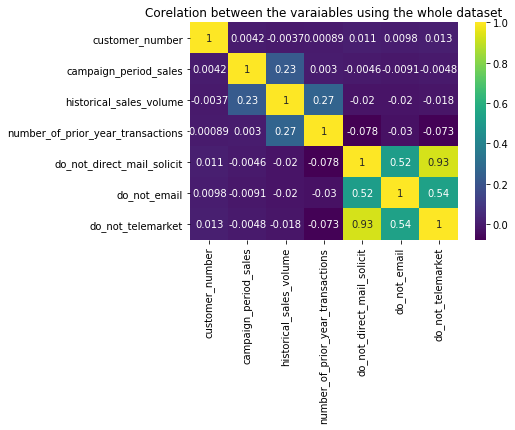

In [26]:
# Corelation between the varaiables using the whole dataset

sns.heatmap(df.corr(), annot=True, cmap='viridis')
plt.title("Corelation between the varaiables using the whole dataset")
print("--"*len('Corelation between the varaiables using the whole dataset'))
plt.show()

* The heatmap shows that `campaign period sales` is corelated with the `historical sale volume`; `historical sale volume` in turn corelated with `number of prior year transaction`. 

### Visualizing the distributions of numerical variables:


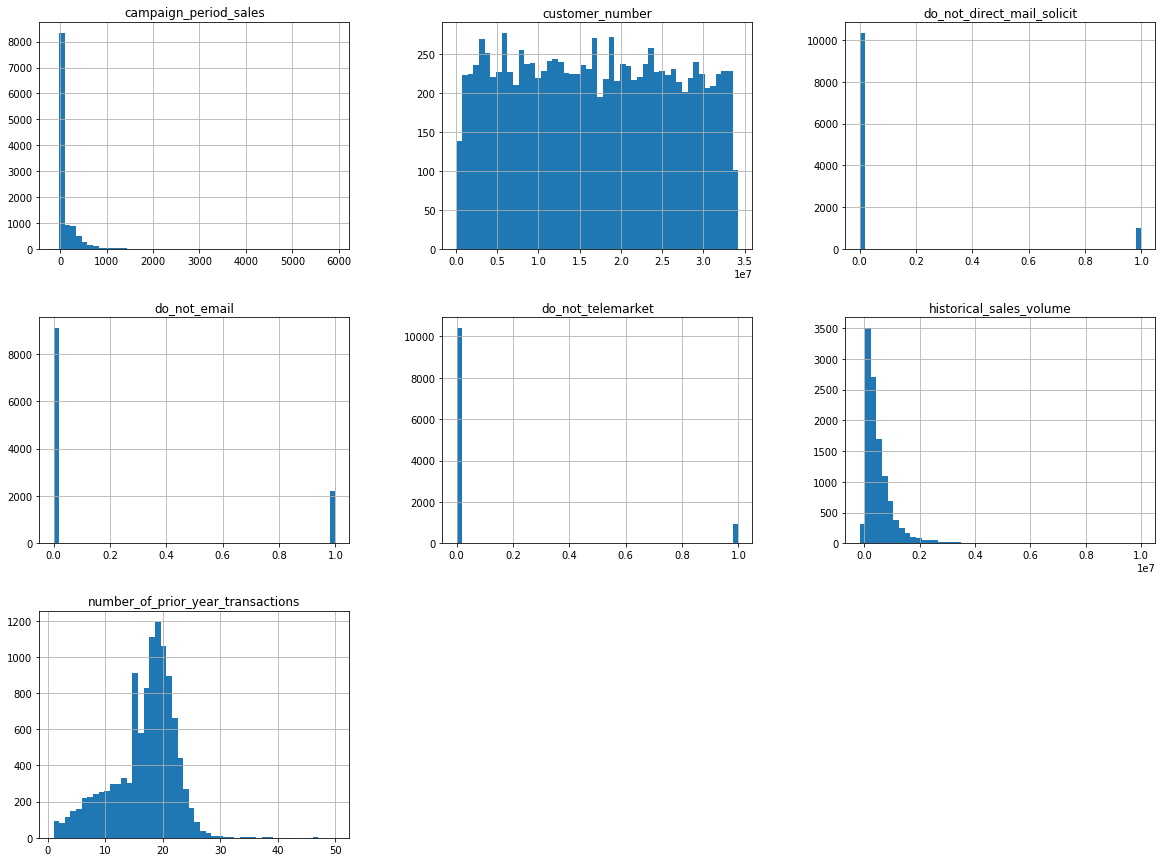

In [28]:
df.hist(bins=50, figsize=(20,15))
plt.show()

## learning about `campaign_period_sales` 

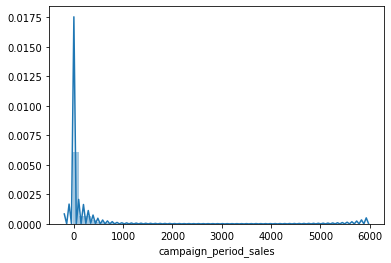

In [29]:
sns.distplot(df['campaign_period_sales']);

## LINEAR REGRESSION

In [33]:
df.columns

Index(['customer_number', 'campaign_period_sales', 'historical_sales_volume',
       'date_of_first_purchase', 'number_of_prior_year_transactions',
       'do_not_direct_mail_solicit', 'do_not_email', 'do_not_telemarket',
       'repurchase_method', 'last_transaction_channel', 'desk',
       'executive_chair', 'standard_chair', 'monitor', 'printer', 'computer',
       'insurance', 'toner', 'office_supplies', 'number_of_employees',
       'language'],
      dtype='object')

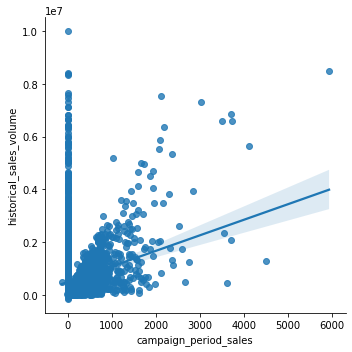

In [36]:
sns.lmplot(x="campaign_period_sales", y="historical_sales_volume", data=df);

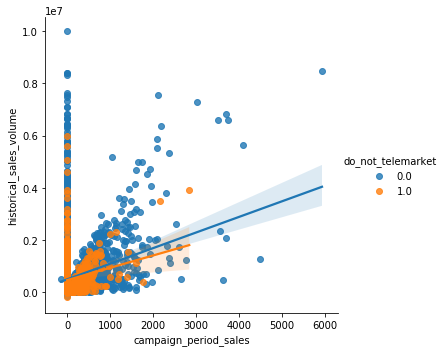

In [38]:
sns.lmplot(x="campaign_period_sales", y="historical_sales_volume",hue="do_not_telemarket", data=df);

## LOGISTIC REGRESSION

0.7304163726182075

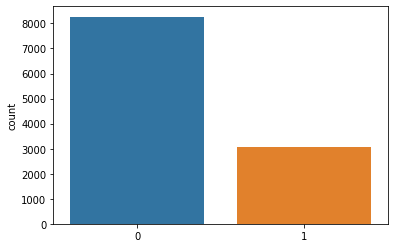

In [40]:
sub_df = df[['campaign_period_sales', 'number_of_prior_year_transactions']].dropna()

buyers = np.where(sub_df['campaign_period_sales'] >0, 1, 0)
sns.countplot(buyers)

X = sub_df[['number_of_prior_year_transactions']]
y = buyers
from sklearn.linear_model import LogisticRegression
lgr= LogisticRegression()
lgr.fit(X,y)

pd.DataFrame(lgr.predict_proba(X))

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y )
lgr = LogisticRegression()
lgr.fit(X_train, y_train)

lgr.score(X_test, y_test)

## Let visualize some data

### Distribution of Campaigni Period Sales

In [41]:
def buy_or_not_buy(x):
    if x > 0:
        return 'Buy'
    else:
        return 'Not_Buy'

In [42]:
df['made_purchase'] = df['campaign_period_sales'].apply(buy_or_not_buy)
df.head()

,customer_number,campaign_period_sales,historical_sales_volume,date_of_first_purchase,number_of_prior_year_transactions,do_not_direct_mail_solicit,do_not_email,do_not_telemarket,repurchase_method,last_transaction_channel,desk,executive_chair,standard_chair,monitor,printer,computer,insurance,toner,office_supplies,number_of_employees,language,made_purchase
0,86734.0,238.704762,146803.428571,1968-10-01,15.0,0.0,0.0,0.0,AUTO RENEW,AUTO RENEW,N,N,N,N,N,N,Y,N,Y,6-10,English,Buy
1,97098.0,281.680000,439984.160000,1981-06-15,22.0,0.0,0.0,0.0,NOTICE,MAIL,N,N,N,N,N,N,N,N,Y,11-50,English,Buy
2,100836.0,432.857143,970465.714286,1962-11-01,19.0,0.0,0.0,0.0,NOTICE,MAIL,N,N,N,N,N,N,N,N,Y,6-10,English,Buy
3,116390.0,0.000000,230193.600000,1983-06-01,17.0,0.0,0.0,0.0,NOTICE,PHONE,N,N,N,N,N,N,N,N,Y,1-5,English,Not_Buy
5,148529.0,308.419048,182584.076190,1979-05-15,16.0,0.0,0.0,0.0,NOTICE,MAIL,N,N,N,N,N,N,N,Y,Y,6-10,English,Buy


In [43]:
df.made_purchase.value_counts()

Not_Buy    8269
Buy        3067
Name: made_purchase, dtype: int64

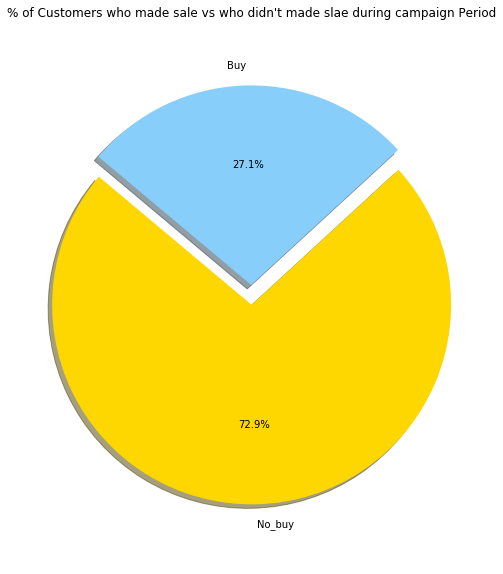

In [44]:
plt.figure(figsize=(8,10))
labels = ["No_buy", "Buy"]
sizes = df.made_purchase.value_counts()
# colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
colors=["gold", "lightskyblue"]
explode = (0.1, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.title("% of Customers who made sale vs who didn't made slae during campaign Period")

plt.axis('equal')
# Save Figure
plt.savefig("resources//Fig1.png")
plt.show()

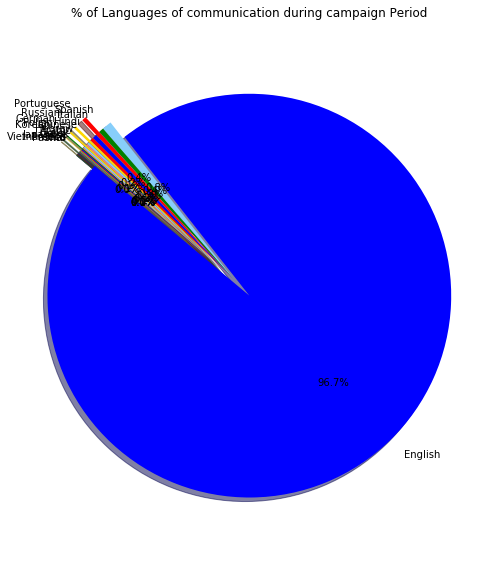

In [45]:
plt.figure(figsize=(8,10))
labels = ["English", "Spanish", "Italian", "Portuguese", "Hindi", "Chinese", "Russian", "Hebrew", "Arabic", "German", 
                "Greek", "Japanese", "Polish", "Vietnamese", "French", "Korean", "Thai", "Pashto"]
sizes = df.language.value_counts()
# colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
colors=["blue", "lightskyblue", "green", "red", "blue", "red", "gold", "lightskyblue",
                "lightcoral", "gold", "lightskyblue", "lightcoral", "green", "blue", "red", "gold", 
                "green", "lightskyblue"]
explode = (0.1, 0, 0, 0.1, 0, 0, 0.1, 0, 0, 0.1, 0, 0, 0.1, 0, 0, 0.1, 0, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.title("% of Languages of communication during campaign Period")

plt.axis('equal')
# Save Figure
plt.savefig("resources/Fig2.png")
plt.show()

## Visualize some variable contribution to the Sale

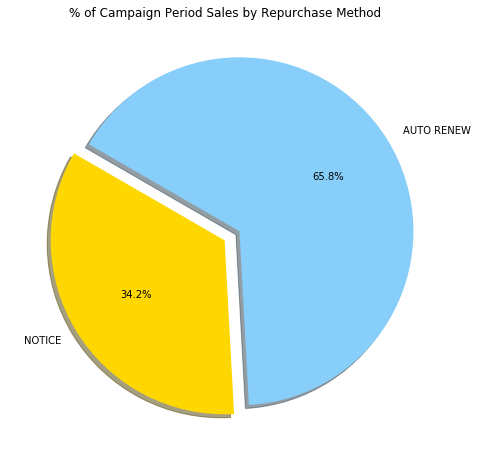

In [46]:
# Calculate Type Percents

type_percents = 100 * df.groupby(["repurchase_method"]).sum()["campaign_period_sales"] / df["campaign_period_sales"].sum()

plt.figure(figsize=(20,8))
# Build Pie Chart
plt.pie(type_percents, 
        labels=["NOTICE", "AUTO RENEW"], 
        colors=["gold", "lightskyblue"], 
        explode=[0, 0.1], 
        autopct='%1.1f%%', 
        shadow=True, startangle=150)
plt.title("% of Campaign Period Sales by Repurchase Method")

# Save Figure
plt.savefig("resources/Fig3.png")

# Show Figure
plt.show()

* It seems that most of the customers made Auto Renewal during their purchase.

In [47]:
paid = df.loc[df['campaign_period_sales']>0]

In [48]:
df.language.value_counts()

English       10964
Spanish          87
Italian          44
Portuguese       40
Hindi            39
Chinese          30
Russian          24
Hebrew           20
Arabic           16
German           15
Greek            14
Japanese         11
Polish           10
Vietnamese        9
French            6
Korean            4
Thai              2
Pashto            1
Name: language, dtype: int64

In [49]:
paid.language.value_counts()

English       2980
Spanish         19
Portuguese      10
Italian          9
Greek            6
Hebrew           6
Chinese          6
Arabic           5
Russian          5
Hindi            5
Japanese         4
German           4
French           2
Vietnamese       2
Polish           2
Pashto           1
Thai             1
Name: language, dtype: int64

* **It seem that Korean language had not contribute for the sale during the campaign.**


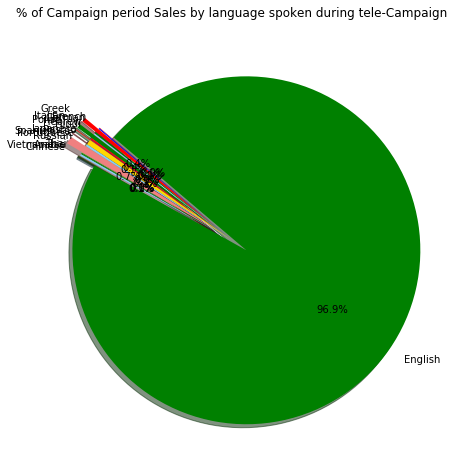

In [50]:
# Calculate share Percents

lang_percents = 100 * paid.groupby(["language"]).sum()["campaign_period_sales"] / paid["campaign_period_sales"].sum()

plt.figure(figsize=(15,8))
# Build Pie Chart
plt.pie(lang_percents, 
        labels=lang_percents.index,
#         labels=["English", "Spanish", "Portuguese", "Italian", "Greek", "Chinese", "Hebrew", "Arabic", "Russian", "Hindi",  "Japanese", "German", "Polish", "Vietnamese", "French", "Thai", "Pashto"], 
        colors=["green", "lightskyblue", "green", "red", "blue", "red", "green", "lightskyblue", "green", "red", "blue", "red", "gold", "lightskyblue","lightcoral", "gold", "green"], 
        explode=[0, 0, 0.1, 0, 0, 0.1, 0, 0, 0.1, 0, 0, 0.1, 0, 0, 0.1, 0, 0], 
        autopct='%1.1f%%', 
        shadow=True, startangle=150)
plt.title("% of Campaign period Sales by language spoken during tele-Campaign")

# Save Figure
plt.savefig("resources/Fig4.png")

# Show Figure
plt.show()


### English language has contribute to about 97% of the sale during the campaign.

----------

## Visualizing Coorelations


### Using Heat Map 

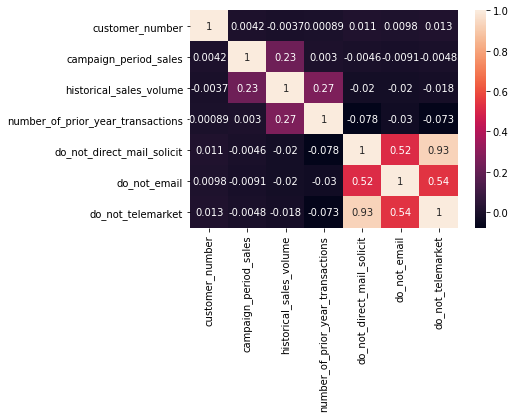

In [52]:
# using nummerical varaiables with whole data

sns.heatmap(df.corr(), annot=True);

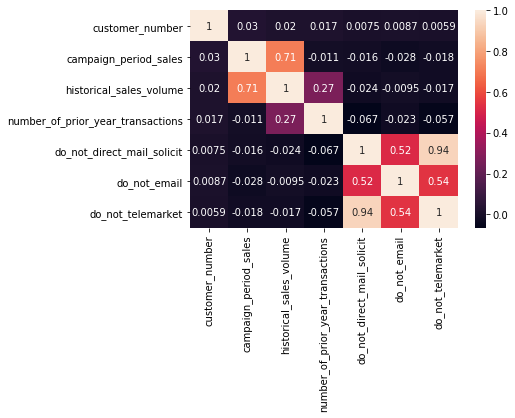

In [54]:
# using nummerical varaiables with the data on thses who made purchase
sns.heatmap(paid.corr(), annot=True);

* **It seems that `campaign period sales` is highly correlated with `Historical sales volume` ~ `71%`**

In [55]:
# explore more features
feature_cols = ['historical_sales_volume',
        'number_of_prior_year_transactions',
       'do_not_direct_mail_solicit', 'do_not_email', 'do_not_telemarket']

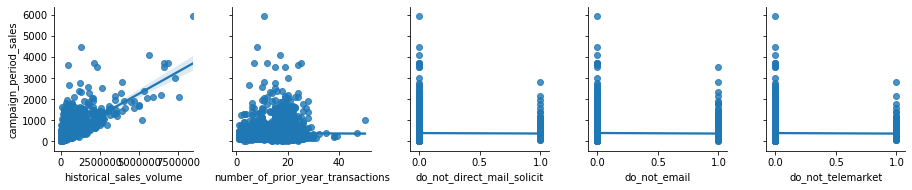

In [57]:
# multiple scatter plots in Seaborn
sns.pairplot(paid, x_vars=feature_cols, y_vars='campaign_period_sales', kind='reg');

* **Linear regression plot still confirming that there is a high correlation between the `campaign period sales` and `hostorical sale volume`.**

In [58]:
df.columns

Index(['customer_number', 'campaign_period_sales', 'historical_sales_volume',
       'date_of_first_purchase', 'number_of_prior_year_transactions',
       'do_not_direct_mail_solicit', 'do_not_email', 'do_not_telemarket',
       'repurchase_method', 'last_transaction_channel', 'desk',
       'executive_chair', 'standard_chair', 'monitor', 'printer', 'computer',
       'insurance', 'toner', 'office_supplies', 'number_of_employees',
       'language', 'made_purchase'],
      dtype='object')

In [59]:
products = ['desk','executive_chair', 'standard_chair', 'monitor', 'printer', 'computer', 'insurance', 'toner', 'office_supplies']
prods = df.loc[:, products]
prods.head()

,desk,executive_chair,standard_chair,monitor,printer,computer,insurance,toner,office_supplies
0,N,N,N,N,N,N,Y,N,Y
1,N,N,N,N,N,N,N,N,Y
2,N,N,N,N,N,N,N,N,Y
3,N,N,N,N,N,N,N,N,Y
5,N,N,N,N,N,N,N,Y,Y


In [60]:
def yner(x):
    if x == 'N':
        return 0
    else:
        return 1

In [61]:
for product in products:
    prods[product] = prods[product].apply(yner)
prods.head()

,desk,executive_chair,standard_chair,monitor,printer,computer,insurance,toner,office_supplies
0,0,0,0,0,0,0,1,0,1
1,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,1
5,0,0,0,0,0,0,0,1,1


In [62]:
df.isnull().sum()

customer_number                      0
campaign_period_sales                0
historical_sales_volume              0
date_of_first_purchase               0
number_of_prior_year_transactions    0
do_not_direct_mail_solicit           0
do_not_email                         0
do_not_telemarket                    0
repurchase_method                    0
last_transaction_channel             0
desk                                 0
executive_chair                      0
standard_chair                       0
monitor                              0
printer                              0
computer                             0
insurance                            0
toner                                0
office_supplies                      0
number_of_employees                  0
language                             0
made_purchase                        0
dtype: int64

In [63]:
df[['language', 'last_transaction_channel']].fillna('unknown').head()

,language,last_transaction_channel
0,English,AUTO RENEW
1,English,MAIL
2,English,MAIL
3,English,PHONE
5,English,MAIL


In [64]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer() # transform or normalize the numberical features

In [65]:
tf= pt.fit_transform(df[['campaign_period_sales', 'historical_sales_volume']])
tf[:,1]


array([-0.66818297, -0.12679912,  0.71131326, ..., -0.83174136,
       -0.43581185,  0.30142364])

In [66]:
df['date_of_first_purchase'] = pd.to_datetime(df['date_of_first_purchase'])
df['year_of_fp']= df['date_of_first_purchase'].dt.year

In [67]:
df['made_purchase'] = df['campaign_period_sales'].apply(buy_or_not_buy)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


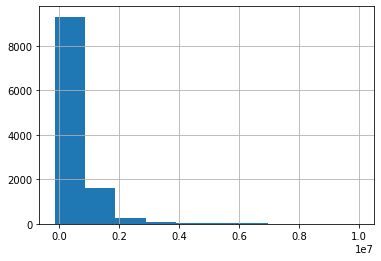

In [68]:
# Normalize the historical_sale_volume
df['historical_sales_volume'].hist()
# plt.hist(np.log(df['historical_sales_volume']))
df['history_log'] = np.log(df['historical_sales_volume'])

In [69]:
def convert_fill_numemploy(val):
    if val == "1-5": return 3
    if val == "6-20": return 8
    if val == "11-50": return 30
    if val == "51-100": return 75
    if val == "1001-500": return 300
    if val == "500+": return 500
    else: return np.nan

In [70]:
df['num_employee_converted'] = df['number_of_employees'].apply(convert_fill_numemploy)

In [71]:
def english_or_not(x):
    if x =='English':
        return 1
    else:
        return 0

In [72]:
df['language'] = df['language'].apply(english_or_not)
df['number_of_employees'] = df['number_of_employees'].apply(convert_fill_numemploy)

In [73]:
def buy_or_not_buy(x):
    if x > 0:
        return 1
    else:
        return 0

In [74]:
df['made_purchase'] = df['campaign_period_sales'].apply(buy_or_not_buy)
df.head()

,customer_number,campaign_period_sales,historical_sales_volume,date_of_first_purchase,number_of_prior_year_transactions,do_not_direct_mail_solicit,do_not_email,do_not_telemarket,repurchase_method,last_transaction_channel,desk,executive_chair,standard_chair,monitor,printer,computer,insurance,toner,office_supplies,number_of_employees,language,made_purchase,year_of_fp,history_log,num_employee_converted
0,86734.0,238.704762,146803.428571,1968-10-01,15.0,0.0,0.0,0.0,AUTO RENEW,AUTO RENEW,N,N,N,N,N,N,Y,N,Y,NaN,1,1,1968,11.896850,NaN
1,97098.0,281.680000,439984.160000,1981-06-15,22.0,0.0,0.0,0.0,NOTICE,MAIL,N,N,N,N,N,N,N,N,Y,30.0,1,1,1981,12.994494,30.0
2,100836.0,432.857143,970465.714286,1962-11-01,19.0,0.0,0.0,0.0,NOTICE,MAIL,N,N,N,N,N,N,N,N,Y,NaN,1,1,1962,13.785531,NaN
3,116390.0,0.000000,230193.600000,1983-06-01,17.0,0.0,0.0,0.0,NOTICE,PHONE,N,N,N,N,N,N,N,N,Y,3.0,1,0,1983,12.346676,3.0
5,148529.0,308.419048,182584.076190,1979-05-15,16.0,0.0,0.0,0.0,NOTICE,MAIL,N,N,N,N,N,N,N,Y,Y,NaN,1,1,1979,12.114966,NaN


In [75]:
def yner(x):
    if x == 'N':
        return 0
    else:
        return 1

In [76]:
products = ['desk','executive_chair', 'standard_chair', 'monitor', 'printer', 'computer', 'insurance', 'toner', 'office_supplies']


In [77]:
for product in products:
    df[product] = df[product].apply(yner)
df.head()

,customer_number,campaign_period_sales,historical_sales_volume,date_of_first_purchase,number_of_prior_year_transactions,do_not_direct_mail_solicit,do_not_email,do_not_telemarket,repurchase_method,last_transaction_channel,desk,executive_chair,standard_chair,monitor,printer,computer,insurance,toner,office_supplies,number_of_employees,language,made_purchase,year_of_fp,history_log,num_employee_converted
0,86734.0,238.704762,146803.428571,1968-10-01,15.0,0.0,0.0,0.0,AUTO RENEW,AUTO RENEW,0,0,0,0,0,0,1,0,1,NaN,1,1,1968,11.896850,NaN
1,97098.0,281.680000,439984.160000,1981-06-15,22.0,0.0,0.0,0.0,NOTICE,MAIL,0,0,0,0,0,0,0,0,1,30.0,1,1,1981,12.994494,30.0
2,100836.0,432.857143,970465.714286,1962-11-01,19.0,0.0,0.0,0.0,NOTICE,MAIL,0,0,0,0,0,0,0,0,1,NaN,1,1,1962,13.785531,NaN
3,116390.0,0.000000,230193.600000,1983-06-01,17.0,0.0,0.0,0.0,NOTICE,PHONE,0,0,0,0,0,0,0,0,1,3.0,1,0,1983,12.346676,3.0
5,148529.0,308.419048,182584.076190,1979-05-15,16.0,0.0,0.0,0.0,NOTICE,MAIL,0,0,0,0,0,0,0,1,1,NaN,1,1,1979,12.114966,NaN


In [78]:
def repurch_method(x):
    if x =='AUTO RENEW':
        return 1
    else:
        return 0

In [79]:
df['re_purch_method'] = df['repurchase_method'].apply(repurch_method)

In [80]:
def last_tran_chan(x):
    if x =='PHONE':
        return 1
    else:
        return 0

In [81]:
df['last_tran_channel'] = df['last_transaction_channel'].apply(repurch_method)

In [82]:
df.head()

,customer_number,campaign_period_sales,historical_sales_volume,date_of_first_purchase,number_of_prior_year_transactions,do_not_direct_mail_solicit,do_not_email,do_not_telemarket,repurchase_method,last_transaction_channel,desk,executive_chair,standard_chair,monitor,printer,computer,insurance,toner,office_supplies,number_of_employees,language,made_purchase,year_of_fp,history_log,num_employee_converted,re_purch_method,last_tran_channel
0,86734.0,238.704762,146803.428571,1968-10-01,15.0,0.0,0.0,0.0,AUTO RENEW,AUTO RENEW,0,0,0,0,0,0,1,0,1,NaN,1,1,1968,11.896850,NaN,1,1
1,97098.0,281.680000,439984.160000,1981-06-15,22.0,0.0,0.0,0.0,NOTICE,MAIL,0,0,0,0,0,0,0,0,1,30.0,1,1,1981,12.994494,30.0,0,0
2,100836.0,432.857143,970465.714286,1962-11-01,19.0,0.0,0.0,0.0,NOTICE,MAIL,0,0,0,0,0,0,0,0,1,NaN,1,1,1962,13.785531,NaN,0,0
3,116390.0,0.000000,230193.600000,1983-06-01,17.0,0.0,0.0,0.0,NOTICE,PHONE,0,0,0,0,0,0,0,0,1,3.0,1,0,1983,12.346676,3.0,0,0
5,148529.0,308.419048,182584.076190,1979-05-15,16.0,0.0,0.0,0.0,NOTICE,MAIL,0,0,0,0,0,0,0,1,1,NaN,1,1,1979,12.114966,NaN,0,0


In [83]:
df.columns

Index(['customer_number', 'campaign_period_sales', 'historical_sales_volume',
       'date_of_first_purchase', 'number_of_prior_year_transactions',
       'do_not_direct_mail_solicit', 'do_not_email', 'do_not_telemarket',
       'repurchase_method', 'last_transaction_channel', 'desk',
       'executive_chair', 'standard_chair', 'monitor', 'printer', 'computer',
       'insurance', 'toner', 'office_supplies', 'number_of_employees',
       'language', 'made_purchase', 'year_of_fp', 'history_log',
       'num_employee_converted', 're_purch_method', 'last_tran_channel'],
      dtype='object')

In [84]:
X = df[['campaign_period_sales', 'historical_sales_volume',
       'date_of_first_purchase', 'number_of_prior_year_transactions',
       'do_not_direct_mail_solicit', 'do_not_email', 'do_not_telemarket', 'desk',
       'executive_chair', 'standard_chair', 'monitor', 'printer', 'computer',
       'insurance', 'toner', 'office_supplies', 'number_of_employees',
       'language', 'made_purchase', 'year_of_fp', 'history_log',
       'num_employee_converted', 're_purch_method', 'last_tran_channel']].dropna()

In [85]:
# X = df[['campaign_period_sales', 'history_log', 'historical_sales_volume', 'number_of_prior_year_transactions', 'year_of_fp', 'made_purchase', 'repurchase_method', 'last_transaction_channel', 'number_of_employees',
#        'language', 'num_employee_converted']].dropna()

In [86]:
X_train, X_test, y_train, y_test = train_test_split( X.iloc[:, :-1], X['made_purchase'], test_size =0.5, train_size=30) # 50 vs 30 split
X_train.head()

,campaign_period_sales,historical_sales_volume,date_of_first_purchase,number_of_prior_year_transactions,do_not_direct_mail_solicit,do_not_email,do_not_telemarket,desk,executive_chair,standard_chair,monitor,printer,computer,insurance,toner,office_supplies,number_of_employees,language,made_purchase,year_of_fp,history_log,num_employee_converted,re_purch_method
2868,176.9264,174803.2832,2009-10-02,13.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,1,3.0,1,1,2009,12.071417,3.0,0
4350,0.0000,409454.7600,1987-07-01,9.0,0.0,1.0,1.0,0,0,0,0,0,0,0,1,1,3.0,1,0,1987,12.922582,3.0,1
14395,307.8400,83116.8000,1994-09-01,9.0,0.0,1.0,0.0,0,0,0,0,0,0,0,0,1,30.0,1,1,1994,11.328002,30.0,1
10545,0.0000,765730.2400,1982-05-01,22.0,0.0,1.0,0.0,0,0,0,0,0,0,0,0,1,30.0,1,0,1982,13.548585,30.0,0
12198,0.0000,61420.8000,1990-11-01,5.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,1,3.0,1,0,1990,11.025504,3.0,0


In [87]:
y_train.value_counts()

0    21
1     9
Name: made_purchase, dtype: int64

## Building a linear regression model

In [88]:
# create X and y
feature_cols = ['historical_sales_volume']
X_f = paid[feature_cols]
y_f = paid.campaign_period_sales

In [89]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X_f,y_f,test_size=0.3,random_state=123)

In [91]:
# import, instantiate and fit the model
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### Predicting on test dataset

In [92]:
lin_test_pred = linreg.predict(X_test)

In [93]:
# print the coefficients
print (linreg.intercept_)
print (linreg.coef_)

195.826821322081
[0.00039449]


### Evaluate the model

### Sum of Squared Error (SSE)

In [94]:
y_test.shape


(921,)

### calculate the SSE.

In [95]:
SSE = 921*(mean_squared_error(y_test,lin_test_pred))
SSE

63877927.70246574

### Mean Squared Error (MSE)

In [96]:
mean_squared_error(y_test,lin_test_pred)

69357.14191364359

### Root Mean Squared Error (RMSE)

In [97]:
np.sqrt(mean_squared_error(y_test,lin_test_pred))

263.3574413485284

### Mean Absolute Error (MAE)

In [98]:
mean_absolute_error(y_test,lin_test_pred)


151.5039105235969

* It seems that Linear Regression with one variable is not doing well!

## Using more Features

In [99]:
# explore more features
more_feature_cols = ['historical_sales_volume',
        'number_of_prior_year_transactions',
       'do_not_direct_mail_solicit', 'do_not_email', 'do_not_telemarket']
X_m = paid[more_feature_cols]
y_m = paid.campaign_period_sales

In [100]:
X_train,X_test,y_train,y_test=train_test_split(X_m,y_m,test_size=0.50)


In [101]:
linreg_mv = LinearRegression()
linreg_mv.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [102]:
lin_test_pred = linreg_mv.predict(X_test)

In [103]:
print("MSE:", mean_squared_error(y_test,lin_test_pred))

print("RMSE:", np.sqrt(mean_squared_error(y_test,lin_test_pred)))
print("MAE:", mean_absolute_error(y_test,lin_test_pred))


MSE: 56330.10040311838
RMSE: 237.33963091552658
MAE: 149.25007199557078


In [104]:
# let include Number of employees

df['number_of_employees'].value_counts()

3.0      2455
30.0     2033
75.0     1264
500.0     210
Name: number_of_employees, dtype: int64

In [105]:
def convert_fill_numemploy(val):
    if val == "1-5": return 3
    if val == "6-20": return 8
    if val == "11-50": return 30
    if val == "51-100": return 75
    if val == "1001-500": return 300
    if val == "500+": return 500
    else: return np.nan
    

In [106]:
df['num_employee_converted'] = df['number_of_employees'].apply(convert_fill_numemploy)

In [107]:
df.loc[df['num_employee_converted'].isnull(), 'num_employee_converted'] = 30.0

In [108]:
df['made_purchase'].value_counts(normalize=True)

0    0.729446
1    0.270554
Name: made_purchase, dtype: float64

In [109]:
# clean = df.loc[:, ['historical_sales_volume', 'number_of_prior_year_transactions', 'year_of_first_purchase', 'made_purchase', 'num_employee_converted']].dropna()
# clean.info()

In [110]:
# clean.columns

----

In [111]:
# sub_df = df[['campaign_period_sale', 'number_of_prior-year_transaction']].dropna()
sub_df = df[['campaign_period_sales','historical_sales_volume',
        'number_of_prior_year_transactions',
       'repurchase_method', 'last_transaction_channel', 'number_of_employees',
       'language']]

In [112]:
buyers = np.where(sub_df['campaign_period_sales'] >0, 1, 0)

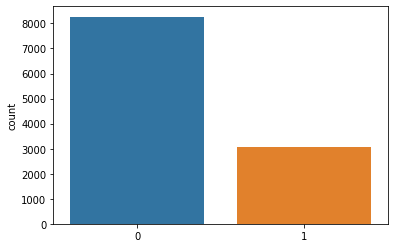

In [114]:
sns.countplot(buyers);

In [115]:
X_s = sub_df[['historical_sales_volume',
        'number_of_prior_year_transactions',
       'repurchase_method', 'last_transaction_channel', 'number_of_employees',
       'language']]
y = buyers

In [116]:
def english_or_not(x):
    if x =='English':
        return 1
    else:
        return 0

In [117]:
X_s['language'] = X_s['language'].apply(english_or_not)
X_s['number_of_employees'] = X_s['number_of_employees'].apply(convert_fill_numemploy)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [118]:
X = pd.get_dummies(X).dropna()

In [119]:
X.head()

,campaign_period_sales,historical_sales_volume,date_of_first_purchase,number_of_prior_year_transactions,do_not_direct_mail_solicit,do_not_email,do_not_telemarket,desk,executive_chair,standard_chair,monitor,printer,computer,insurance,toner,office_supplies,number_of_employees,language,made_purchase,year_of_fp,history_log,num_employee_converted,re_purch_method,last_tran_channel
1,281.68,439984.16,1981-06-15,22.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,1,30.0,1,1,1981,12.994494,30.0,0,0
3,0.00,230193.60,1983-06-01,17.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,1,3.0,1,0,1983,12.346676,3.0,0,0
6,0.00,151252.50,1986-11-15,6.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,75.0,1,0,1986,11.926706,75.0,0,0
9,223.44,277512.48,1982-07-01,18.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,1,3.0,1,1,1982,12.533621,3.0,0,0
11,124.76,199366.48,1980-09-01,17.0,0.0,1.0,0.0,0,0,0,0,0,0,0,0,1,3.0,1,1,1980,12.202900,3.0,0,0


In [122]:
# X = df[['campaign_period_sales', 'history_log', 'historical_sales_volume', 'number_of_prior_year_transactions', 'year_of_fp', 'made_purchase']].dropna()


X = df[['campaign_period_sales', 'history_log', 'historical_sales_volume',
        'number_of_prior_year_transactions', 'year_of_fp',
       'do_not_direct_mail_solicit', 'do_not_email', 'do_not_telemarket', 'desk',
       'executive_chair', 'standard_chair', 'monitor', 'printer', 'computer',
       'insurance', 'toner', 'office_supplies', 'number_of_employees',
       'language', 'made_purchase', 'year_of_fp', 'history_log',
       'num_employee_converted', 're_purch_method', 'last_tran_channel']].dropna()


X_train, X_test, y_train, y_test = train_test_split(X.iloc[:, :-1], X['made_purchase'], test_size =0.5) # 50 vs 30 split
X_train.head()

,campaign_period_sales,history_log,historical_sales_volume,number_of_prior_year_transactions,year_of_fp,do_not_direct_mail_solicit,do_not_email,do_not_telemarket,desk,executive_chair,standard_chair,monitor,printer,computer,insurance,toner,office_supplies,number_of_employees,language,made_purchase,year_of_fp,history_log,num_employee_converted,re_purch_method
4242,0.000000,13.479878,714885.600000,15.0,1996,0.0,0.0,0.0,0,0,0,0,0,0,0,0,1,30.0,1,0,1996,13.479878,30.0,1
14486,223.426667,12.099926,179858.466667,7.0,1992,0.0,0.0,0.0,0,0,0,0,0,0,0,1,1,3.0,1,1,1992,12.099926,30.0,0
6672,0.000000,12.006743,163856.000000,38.0,1979,0.0,0.0,0.0,0,0,0,0,0,0,0,1,1,3.0,1,0,1979,12.006743,30.0,0
5552,0.000000,11.554661,104261.866667,16.0,1997,0.0,0.0,0.0,0,0,0,0,0,0,1,0,1,75.0,0,0,1997,11.554661,30.0,0
3504,0.000000,13.317093,607491.456000,23.0,1995,0.0,0.0,0.0,0,0,0,0,0,0,1,0,1,30.0,1,0,1995,13.317093,30.0,1


In [123]:
y_train.value_counts()

0    2160
1     819
Name: made_purchase, dtype: int64

In [124]:
y_tr_reg = X_train['campaign_period_sales']
y_test_reg = X_test['campaign_period_sales']

In [125]:
from sklearn.linear_model import LinearRegression, LogisticRegression
clf = LogisticRegression()
clf.fit(X_train.iloc[:, 1:], y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [126]:
for col, coef in zip(['history', 'num_prior', 'year'], clf.coef_[0]):
    print(col, coef)

history -1.2986593169640626e-06
num_prior -1.959955211215981e-07
year -1.4797295316916798e-06


In [127]:
# NB. Two thing we are predicting: whether or not they made a made_purchase - Classification problem and How much they bought - regression problem.

# NB. Put more features later

clf.predict_proba(X_test.iloc[:, 1:]) #we need the second column, the probability of beig +ev
probs = clf.predict_proba(X_test.iloc[:, 1:])[:, 1]
pred = clf.predict(X_test.iloc[:, 1:])

In [129]:
# Now regerssion Model
reg = LinearRegression()
reg.fit(X_train.iloc[:, 1:], y_tr_reg)
pred_sales = reg.predict(X_test.iloc[:, 1:])

In [130]:
ans_df = pd.DataFrame({'sales': pred_sales, 'prob': probs}) # 2 models- prediction and regression.

## Probability of Sales

In [132]:
ans_df['profit'] = .22*ans_df['sales'] - 8.4*ans_df['sales'] - 45.65
ans_df.head()

,sales,prob,profit
0,327.472528,0.287657,-2724.375277
1,-26.053241,0.288996,167.465514
2,23.566445,0.251173,-238.423520
3,303.600872,0.291359,-2529.105136
4,20.912930,0.287838,-216.717766


In [133]:
ans_df['group'] = pd.qcut(ans_df['profit'], 10, duplicates='drop')

In [134]:
ans_df.groupby('group').mean().sort_values(by='profit', ascending=False)

,sales,prob,profit
group,,,
"(428.603, 998.24]",-77.523391,0.290558,588.491335
"(280.694, 428.603]",-48.160998,0.285071,348.306963
"(132.456, 280.694]",-31.140484,0.282442,209.079158
"(-7.914, 132.456]",-13.455715,0.277347,64.417747
"(-168.715, -7.914]",4.240124,0.271937,-80.334213
"(-368.785, -168.715]",26.011342,0.266490,-258.422776
"(-1898.824, -368.785]",65.925629,0.253090,-584.921645
"(-2919.199, -1898.824]",325.123014,0.275582,-2705.156253
"(-3303.992, -2919.199]",376.480389,0.273082,-3125.259583


In [135]:
lift_chart = ans_df.groupby('group').mean().sort_values(by='profit', ascending=False)

In [136]:
lift_chart['size'] = ans_df.groupby('group').size()

lift_chart

,sales,prob,profit,size
group,,,,
"(428.603, 998.24]",-77.523391,0.290558,588.491335,298
"(280.694, 428.603]",-48.160998,0.285071,348.306963,298
"(132.456, 280.694]",-31.140484,0.282442,209.079158,298
"(-7.914, 132.456]",-13.455715,0.277347,64.417747,298
"(-168.715, -7.914]",4.240124,0.271937,-80.334213,297
"(-368.785, -168.715]",26.011342,0.266490,-258.422776,298
"(-1898.824, -368.785]",65.925629,0.253090,-584.921645,298
"(-2919.199, -1898.824]",325.123014,0.275582,-2705.156253,298
"(-3303.992, -2919.199]",376.480389,0.273082,-3125.259583,298


In [137]:
lift_chart['total_profit'] = lift_chart['size'] * lift_chart['profit']

lift_chart

,sales,prob,profit,size,total_profit
group,,,,,
"(428.603, 998.24]",-77.523391,0.290558,588.491335,298,1.753704e+05
"(280.694, 428.603]",-48.160998,0.285071,348.306963,298,1.037955e+05
"(132.456, 280.694]",-31.140484,0.282442,209.079158,298,6.230559e+04
"(-7.914, 132.456]",-13.455715,0.277347,64.417747,298,1.919649e+04
"(-168.715, -7.914]",4.240124,0.271937,-80.334213,297,-2.385926e+04
"(-368.785, -168.715]",26.011342,0.266490,-258.422776,298,-7.700999e+04
"(-1898.824, -368.785]",65.925629,0.253090,-584.921645,298,-1.743067e+05
"(-2919.199, -1898.824]",325.123014,0.275582,-2705.156253,298,-8.061366e+05
"(-3303.992, -2919.199]",376.480389,0.273082,-3125.259583,298,-9.313274e+05


In [138]:
lift_chart.set_index = [i for i in range(1, 11)]
lift_chart

,sales,prob,profit,size,total_profit
group,,,,,
"(428.603, 998.24]",-77.523391,0.290558,588.491335,298,1.753704e+05
"(280.694, 428.603]",-48.160998,0.285071,348.306963,298,1.037955e+05
"(132.456, 280.694]",-31.140484,0.282442,209.079158,298,6.230559e+04
"(-7.914, 132.456]",-13.455715,0.277347,64.417747,298,1.919649e+04
"(-168.715, -7.914]",4.240124,0.271937,-80.334213,297,-2.385926e+04
"(-368.785, -168.715]",26.011342,0.266490,-258.422776,298,-7.700999e+04
"(-1898.824, -368.785]",65.925629,0.253090,-584.921645,298,-1.743067e+05
"(-2919.199, -1898.824]",325.123014,0.275582,-2705.156253,298,-8.061366e+05
"(-3303.992, -2919.199]",376.480389,0.273082,-3125.259583,298,-9.313274e+05


In [139]:
avg_profit = lift_chart['profit'].mean()
lift_chart['lift_over_avg'] = lift_chart['profit'] - avg_profit
lift_chart

,sales,prob,profit,size,total_profit,lift_over_avg
group,,,,,,
"(428.603, 998.24]",-77.523391,0.290558,588.491335,298,1.753704e+05,1543.734660
"(280.694, 428.603]",-48.160998,0.285071,348.306963,298,1.037955e+05,1303.550288
"(132.456, 280.694]",-31.140484,0.282442,209.079158,298,6.230559e+04,1164.322483
"(-7.914, 132.456]",-13.455715,0.277347,64.417747,298,1.919649e+04,1019.661072
"(-168.715, -7.914]",4.240124,0.271937,-80.334213,297,-2.385926e+04,874.909113
"(-368.785, -168.715]",26.011342,0.266490,-258.422776,298,-7.700999e+04,696.820549
"(-1898.824, -368.785]",65.925629,0.253090,-584.921645,298,-1.743067e+05,370.321680
"(-2919.199, -1898.824]",325.123014,0.275582,-2705.156253,298,-8.061366e+05,-1749.912928
"(-3303.992, -2919.199]",376.480389,0.273082,-3125.259583,298,-9.313274e+05,-2170.016258


In [140]:
lift_chart['per_of_profit'] = lift_chart['profit']/lift_chart['profit'].sum()
lift_chart

,sales,prob,profit,size,total_profit,lift_over_avg,per_of_profit
group,,,,,,,
"(428.603, 998.24]",-77.523391,0.290558,588.491335,298,1.753704e+05,1543.734660,-0.061606
"(280.694, 428.603]",-48.160998,0.285071,348.306963,298,1.037955e+05,1303.550288,-0.036463
"(132.456, 280.694]",-31.140484,0.282442,209.079158,298,6.230559e+04,1164.322483,-0.021888
"(-7.914, 132.456]",-13.455715,0.277347,64.417747,298,1.919649e+04,1019.661072,-0.006744
"(-168.715, -7.914]",4.240124,0.271937,-80.334213,297,-2.385926e+04,874.909113,0.008410
"(-368.785, -168.715]",26.011342,0.266490,-258.422776,298,-7.700999e+04,696.820549,0.027053
"(-1898.824, -368.785]",65.925629,0.253090,-584.921645,298,-1.743067e+05,370.321680,0.061233
"(-2919.199, -1898.824]",325.123014,0.275582,-2705.156253,298,-8.061366e+05,-1749.912928,0.283190
"(-3303.992, -2919.199]",376.480389,0.273082,-3125.259583,298,-9.313274e+05,-2170.016258,0.327169


In [141]:
lift_chart['incr_proj_profit_100k_cust_base'] = lift_chart['lift_over_avg']*10
lift_chart

,sales,prob,profit,size,total_profit,lift_over_avg,per_of_profit,incr_proj_profit_100k_cust_base
group,,,,,,,,
"(428.603, 998.24]",-77.523391,0.290558,588.491335,298,1.753704e+05,1543.734660,-0.061606,15437.346596
"(280.694, 428.603]",-48.160998,0.285071,348.306963,298,1.037955e+05,1303.550288,-0.036463,13035.502878
"(132.456, 280.694]",-31.140484,0.282442,209.079158,298,6.230559e+04,1164.322483,-0.021888,11643.224832
"(-7.914, 132.456]",-13.455715,0.277347,64.417747,298,1.919649e+04,1019.661072,-0.006744,10196.610723
"(-168.715, -7.914]",4.240124,0.271937,-80.334213,297,-2.385926e+04,874.909113,0.008410,8749.091126
"(-368.785, -168.715]",26.011342,0.266490,-258.422776,298,-7.700999e+04,696.820549,0.027053,6968.205491
"(-1898.824, -368.785]",65.925629,0.253090,-584.921645,298,-1.743067e+05,370.321680,0.061233,3703.216804
"(-2919.199, -1898.824]",325.123014,0.275582,-2705.156253,298,-8.061366e+05,-1749.912928,0.283190,-17499.129276
"(-3303.992, -2919.199]",376.480389,0.273082,-3125.259583,298,-9.313274e+05,-2170.016258,0.327169,-21700.162576


In [142]:
lift_chart['total_proj_profit_100k_cust_base'] = lift_chart['profit']*10
lift_chart

,sales,prob,profit,size,total_profit,lift_over_avg,per_of_profit,incr_proj_profit_100k_cust_base,total_proj_profit_100k_cust_base
group,,,,,,,,,
"(428.603, 998.24]",-77.523391,0.290558,588.491335,298,1.753704e+05,1543.734660,-0.061606,15437.346596,5884.913345
"(280.694, 428.603]",-48.160998,0.285071,348.306963,298,1.037955e+05,1303.550288,-0.036463,13035.502878,3483.069627
"(132.456, 280.694]",-31.140484,0.282442,209.079158,298,6.230559e+04,1164.322483,-0.021888,11643.224832,2090.791581
"(-7.914, 132.456]",-13.455715,0.277347,64.417747,298,1.919649e+04,1019.661072,-0.006744,10196.610723,644.177472
"(-168.715, -7.914]",4.240124,0.271937,-80.334213,297,-2.385926e+04,874.909113,0.008410,8749.091126,-803.342125
"(-368.785, -168.715]",26.011342,0.266490,-258.422776,298,-7.700999e+04,696.820549,0.027053,6968.205491,-2584.227760
"(-1898.824, -368.785]",65.925629,0.253090,-584.921645,298,-1.743067e+05,370.321680,0.061233,3703.216804,-5849.216447
"(-2919.199, -1898.824]",325.123014,0.275582,-2705.156253,298,-8.061366e+05,-1749.912928,0.283190,-17499.129276,-27051.562527
"(-3303.992, -2919.199]",376.480389,0.273082,-3125.259583,298,-9.313274e+05,-2170.016258,0.327169,-21700.162576,-31252.595827


In [143]:
lift_chart['cuml_proj_profit_100k_cust_base'] = lift_chart['incr_proj_profit_100k_cust_base'].cumsum()
lift_chart

,sales,prob,profit,size,total_profit,lift_over_avg,per_of_profit,incr_proj_profit_100k_cust_base,total_proj_profit_100k_cust_base,cuml_proj_profit_100k_cust_base
group,,,,,,,,,,
"(428.603, 998.24]",-77.523391,0.290558,588.491335,298,1.753704e+05,1543.734660,-0.061606,15437.346596,5884.913345,15437.346596
"(280.694, 428.603]",-48.160998,0.285071,348.306963,298,1.037955e+05,1303.550288,-0.036463,13035.502878,3483.069627,28472.849474
"(132.456, 280.694]",-31.140484,0.282442,209.079158,298,6.230559e+04,1164.322483,-0.021888,11643.224832,2090.791581,40116.074306
"(-7.914, 132.456]",-13.455715,0.277347,64.417747,298,1.919649e+04,1019.661072,-0.006744,10196.610723,644.177472,50312.685029
"(-168.715, -7.914]",4.240124,0.271937,-80.334213,297,-2.385926e+04,874.909113,0.008410,8749.091126,-803.342125,59061.776154
"(-368.785, -168.715]",26.011342,0.266490,-258.422776,298,-7.700999e+04,696.820549,0.027053,6968.205491,-2584.227760,66029.981645
"(-1898.824, -368.785]",65.925629,0.253090,-584.921645,298,-1.743067e+05,370.321680,0.061233,3703.216804,-5849.216447,69733.198449
"(-2919.199, -1898.824]",325.123014,0.275582,-2705.156253,298,-8.061366e+05,-1749.912928,0.283190,-17499.129276,-27051.562527,52234.069173
"(-3303.992, -2919.199]",376.480389,0.273082,-3125.259583,298,-9.313274e+05,-2170.016258,0.327169,-21700.162576,-31252.595827,30533.906597


In [144]:
lift_chart['cuml_total_profit_100k_cust_base'] = lift_chart['total_proj_profit_100k_cust_base'].cumsum()
lift_chart

,sales,prob,profit,size,total_profit,lift_over_avg,per_of_profit,incr_proj_profit_100k_cust_base,total_proj_profit_100k_cust_base,cuml_proj_profit_100k_cust_base,cuml_total_profit_100k_cust_base
group,,,,,,,,,,,
"(428.603, 998.24]",-77.523391,0.290558,588.491335,298,1.753704e+05,1543.734660,-0.061606,15437.346596,5884.913345,15437.346596,5884.913345
"(280.694, 428.603]",-48.160998,0.285071,348.306963,298,1.037955e+05,1303.550288,-0.036463,13035.502878,3483.069627,28472.849474,9367.982973
"(132.456, 280.694]",-31.140484,0.282442,209.079158,298,6.230559e+04,1164.322483,-0.021888,11643.224832,2090.791581,40116.074306,11458.774553
"(-7.914, 132.456]",-13.455715,0.277347,64.417747,298,1.919649e+04,1019.661072,-0.006744,10196.610723,644.177472,50312.685029,12102.952025
"(-168.715, -7.914]",4.240124,0.271937,-80.334213,297,-2.385926e+04,874.909113,0.008410,8749.091126,-803.342125,59061.776154,11299.609900
"(-368.785, -168.715]",26.011342,0.266490,-258.422776,298,-7.700999e+04,696.820549,0.027053,6968.205491,-2584.227760,66029.981645,8715.382140
"(-1898.824, -368.785]",65.925629,0.253090,-584.921645,298,-1.743067e+05,370.321680,0.061233,3703.216804,-5849.216447,69733.198449,2866.165693
"(-2919.199, -1898.824]",325.123014,0.275582,-2705.156253,298,-8.061366e+05,-1749.912928,0.283190,-17499.129276,-27051.562527,52234.069173,-24185.396834
"(-3303.992, -2919.199]",376.480389,0.273082,-3125.259583,298,-9.313274e+05,-2170.016258,0.327169,-21700.162576,-31252.595827,30533.906597,-55437.992660
